## Import modules

In [56]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re
import urllib
import os
from tqdm import tqdm
import random


# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding
#from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/PERSONALE/francesco.durazzi2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/PERSONALE/francesco.durazzi2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/PERSONALE/francesco.durazzi2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Set some matplotlib configs for visualization

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [3]:
# Set only one GPU device to be visibile: comment if there are not multiple GPUs
os.environ["CUDA_VISIBLE_DEVICES"]="5" 

# Document classification through word2vec embeddings and BiLSTM Recurrent Neural Networks
The aim of this notebook is to show how we can train a neural network to discriminate between negative and positive movie reviews taken from Imdb. 

After the data downloading and preparations, we are going to tokenize and lemmatize each review.
Then we are going to learn vector embeddings of each token with word2vec algorithm, whose objective is to provide similar vectors to the words that are usually used close together in the corpus.
Finally, we will train a Bi-directional LSTM neural network to classificate positive and negative reviews. A single network input is one review in the form of a sequence of token vector embeddings generated by word2vec.

Credits: this notebook is an adapted version of: https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc#

## Import data

In [5]:
urllib.request.urlretrieve('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', 'data/movie_reviews.tar.gz')
!tar -xzf data/movie_reviews.tar.gz --directory data;

('data/movie_reviews.tar.gz', <http.client.HTTPMessage at 0x7fb15aa9edf0>)

In [4]:
train_dir='data/aclImdb/train/'

In [5]:
lab2num={'neg':0,'pos':1}
df=pd.DataFrame(columns=['id','review','rating','label'])
for directory in ['neg/','pos/','unsup/']:
    file_list=[f for f in os.listdir(train_dir+directory)]
    for file in tqdm(file_list):
        with open (train_dir+directory+file, "r") as opfile:
            text=opfile.read()
        movie_id=file.split('_')[0]
        rating=int(file[:-4].split('_')[1])
        df.loc[df.shape[0],:]=[movie_id,text,rating,directory[:-1]]
df['sentiment']=df['label'].map(lab2num)
df['rating']=pd.to_numeric(df['rating'])

100%|██████████| 50000/50000 [07:28<00:00, 111.50it/s]


In [6]:
df

,id,review,rating,label,sentiment
0,6727,The Soloist has all ingredients to impress the...,4,neg,0.0
1,3190,Jimmy Dean could not have been more hammy or a...,1,neg,0.0
2,3984,I saw this movie a few years back on the BBC i...,1,neg,0.0
3,4727,This film is really something of a curate's eg...,4,neg,0.0
4,4414,Christopher Durang must have been taught by a ...,3,neg,0.0
...,...,...,...,...,...
74995,13800,I found this at my lending library. I've alway...,0,unsup,NaN
74996,29113,Long Time Dead opens to a caption that informs...,0,unsup,NaN
74997,970,Take a couple of con men who see an opportunit...,0,unsup,NaN
74998,40728,"With a name like ""Karate Cop"", what are you re...",0,unsup,NaN


In [7]:
df_train=df[df.label!='unsup']
print(df_train.shape)

(25000, 5)


In [8]:
all_reviews = np.array(df.review.values, dtype=str)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 75000


## Check class balance

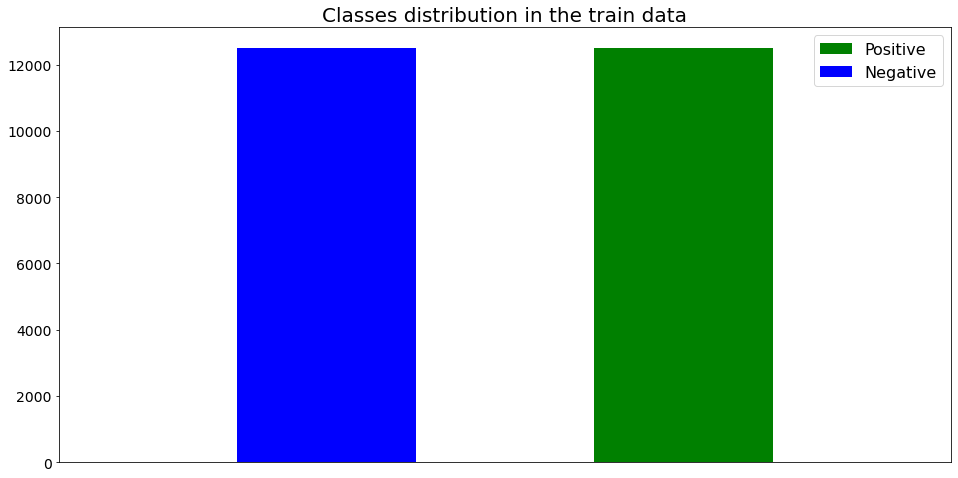

In [49]:
plt.hist(df_train[df_train.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(df_train[df_train.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [9]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [10]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [11]:
#Lemmatization example
lemmatizer.lemmatize('fishes')

'fish'

In [15]:
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

In [17]:
X_train_data = all_reviews[:df_train.shape[0]]
Y_train_data = df_train.sentiment.values

In [18]:
df_train['review_lenght'] = np.array(list(map(len, X_train_data)))
median = df_train['review_lenght'].median()
mean = df_train['review_lenght'].mean()
mode = df_train['review_lenght'].mode()[0]

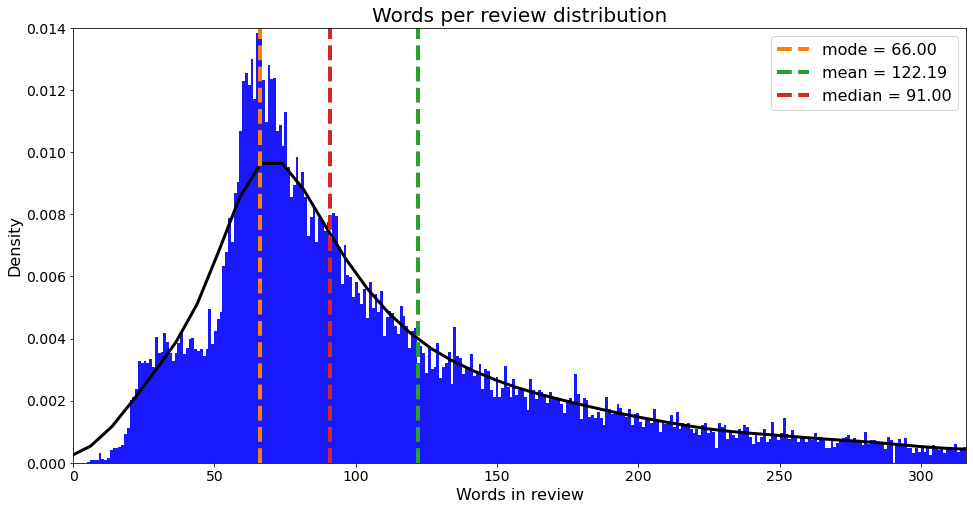

In [19]:
fig, ax = plt.subplots()
sb.distplot(df_train['review_lenght'], bins=df_train['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(df_train['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

## Word2vec embedding generation

In [20]:
%%time
bigrams = Phrases(sentences=all_reviews)

CPU times: user 22.7 s, sys: 228 ms, total: 22.9 s
Wall time: 22.9 s


In [21]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

CPU times: user 1min 12s, sys: 447 ms, total: 1min 13s
Wall time: 1min 13s


In [23]:
df_train.review.iloc[0]

"The Soloist has all ingredients to impress the Academy. Its director, Joe Wright, has already authored a best picture candidate. The leading actor, Robert Downey Jr., starred in a widely praised superhero film. Finally, the movie itself is a drama. When it was mysteriously pulled from release in late 2008, filmgoers and critics were baffled. Now that I've seen it, I assure you Universal didn't just delay this film to promote Iron Man-Oscar buzz. The Soloist is a weak drama with no external conflict that is vastly inferior to any 2009 best picture candidates.<br /><br />Downey and co-star Jamie Fox aren't to be blamed for this mishap. Joe Wright is largely at fault but even he can't save a Lifetime story. Many movies are too complex and alienate viewers. This one is unusually simple. It's a movie about a newspaper reporter, Steve Lopez (Downey), who befriends a homeless musician, Nathaniel Ayers (Jamie Fox). That's it. Ayers is schizophrenic and doesn't resonate with Lopez's traditiona

Now we can use gensim's phrases to find bigrams or trigrams

In [27]:
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [28]:
%%time
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=32)

CPU times: user 12min 55s, sys: 3.39 s, total: 12min 59s
Wall time: 11min 10s


In [29]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 77483


And now we can use gensim's word2vec model to build a word embedding. Also we can use the word2vec model to define most similar words, calculate diffence between the words, etc.

In [31]:
trigrams_model.wv.most_similar('hero')

[('bad_guy', 0.7040280699729919),
 ('villain', 0.7019020318984985),
 ('baddie', 0.664642333984375),
 ('anti_hero', 0.6371986865997314),
 ('rykker', 0.6182281374931335),
 ('antagonist', 0.5847554802894592),
 ('heroic', 0.5708339214324951),
 ('enemy', 0.5584995746612549),
 ('foe', 0.5581262707710266),
 ('heroine', 0.5543303489685059)]

In [32]:
trigrams_model.wv.doesnt_match(['hero', 'fight', 'power', 'food'])

'food'

Each vector lives in a 256-dimensional space, but for visualization purposes we can project each vector into a bi-dimensional space through dimensionality reduction.
Here we apply Principal Component Analysis, that projects the data on the eigenvectors of the covariance matrix.

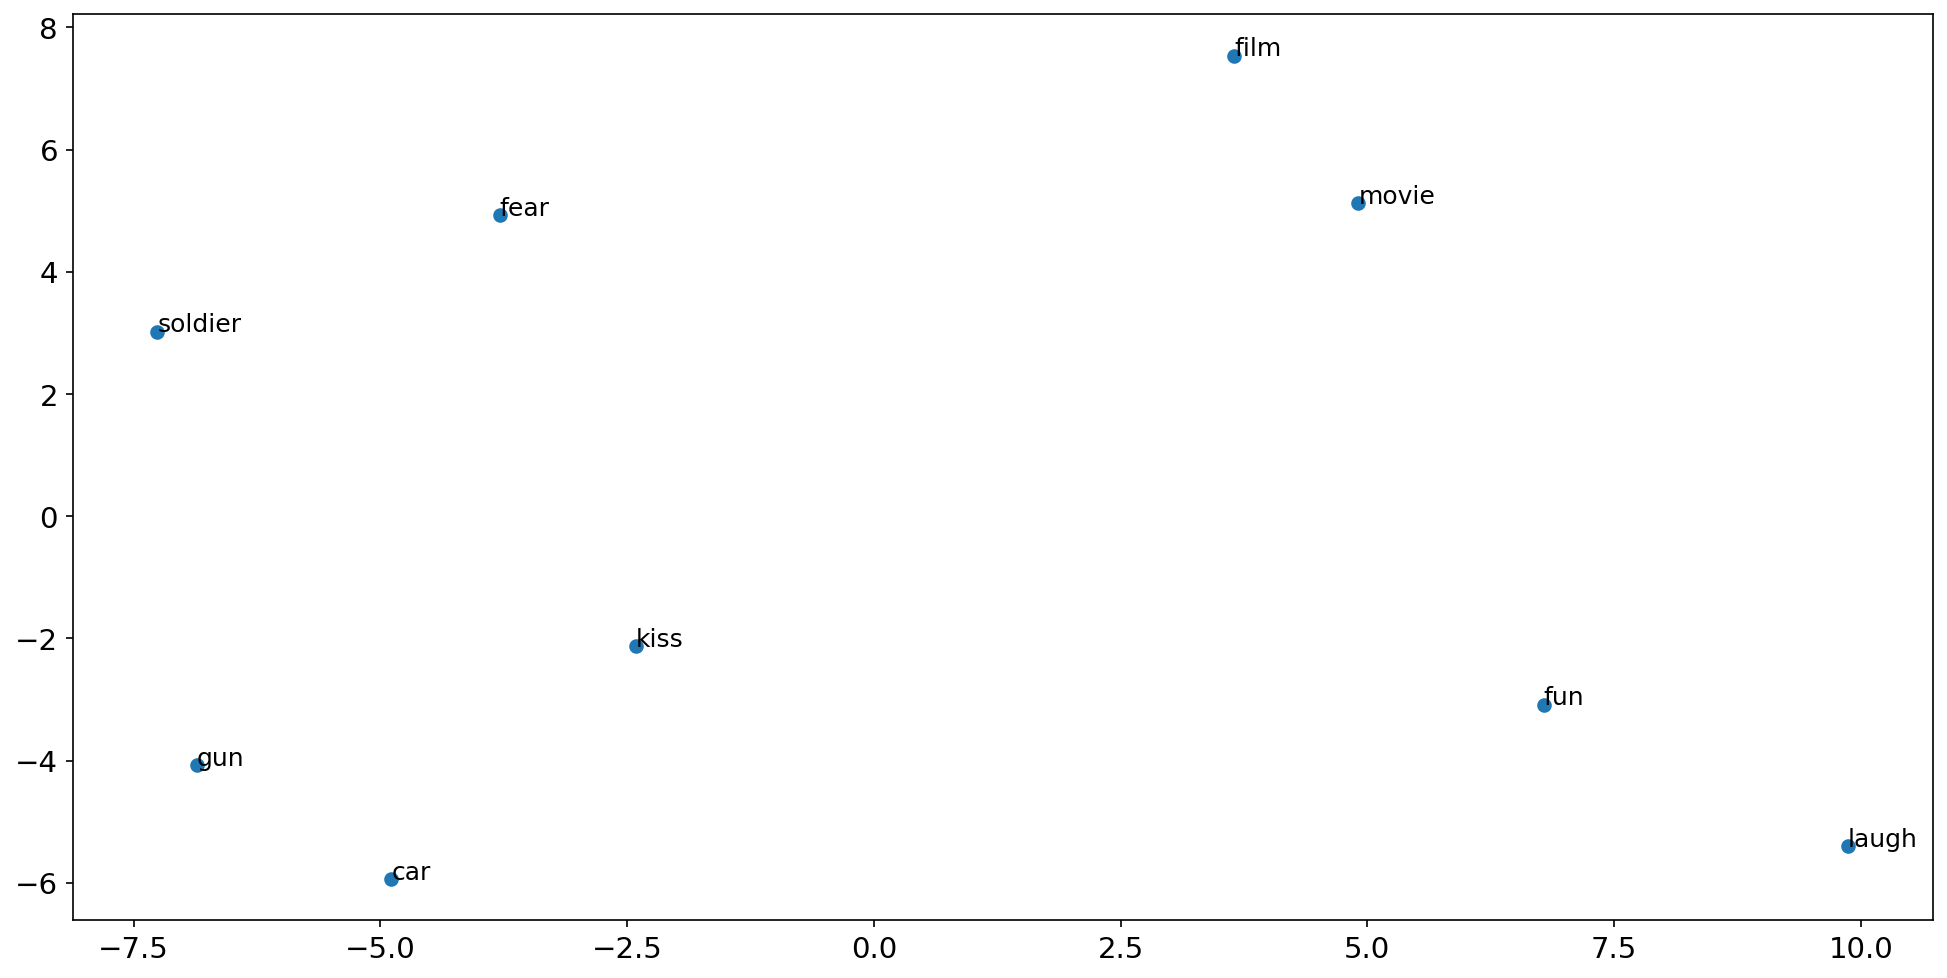

In [47]:
random.seed(721)
words_to_print=['movie','film','fun','fear','laugh','gun','kiss','car','food','']
words_vecs=[]
for w in words_to_print:
    words_vecs.append(trigrams_model.wv.get_vector(w))

words_vecs=PCA(2,random_state=721).fit_transform(np.array(words_vecs))
x=words_vecs[:,0]
y=words_vecs[:,1]

fig = plt.figure(dpi=150)
plt.scatter(x, y)
for i, txt in enumerate(words_to_print):
    plt.annotate(txt, (x[i], y[i]))

A word2vec embedding depends on the corpus you used for training the word2vec model. For example "gun" and "car" would probably been very distant if we trained the model on a corpus made of industrial documents. 

On the other hand, it has the advantage of being task independent. We can use the same embeddings for document classifcation, clustering or text-generation. The vectore embedding has learned the proximity of the words, that is not an information specific of the sentinment classification task we are going to apply in the next paragraphs.

## Training the BiLSTM network for document classification

We want to train a neural network that can discriminate between positive and negative reviews (classification problem). The network does not accept directly the sequences in the form of strings or list of strings. We have to vectorize each sequence, by translating each token in the sentence to its index in the vocabulary.

We also make the sequences to have the same length, by truncating the longest ones and padding the shortest ones. In this way we are losing all the information that is being truncated, but the training process is lighter and faster.

In [49]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    # Remove words that have no embedding in the word2vec (occurred less thant 3 times in the corpus)
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, tqdm(data)))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

  0%|          | 32/25000 [00:00<01:21, 305.26it/s]

Convert sentences to sentences with ngrams... (done)


100%|██████████| 25000/25000 [04:27<00:00, 93.36it/s] 


Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 4min 27s, sys: 832 ms, total: 4min 28s
Wall time: 4min 28s


We train the network on 95% of the training set, and use the remaining 5% as validation set to monitor the improvement of the network during the training process.

In [50]:
X_train, X_val, y_train, y_val = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.05,
    shuffle=True,
    random_state=721)

We use a Recurrent Neural Network with Bi-directional Long Short-Term memory cells (BiLSTM network). The core of this architecture is the a the layer composed of multiple LSTMs that process the input recursively with LTSM cells that remember values over arbitrary time intervals thanks to the three gates that regulate the flow of information into and out of the cell.
Bi-directionality is introduced by duplicating the LSTM layer and feeding left-to-right inputs to the first one and right-to-left inputs to the second one. 

The first layer of the network is an Embedding layer. It is nothing more than a lookup matrix, that maps each token in the document to its vector representation. In our case, it simply translate each token index to its word2vec vector that we computed before. In general we could have asked the network to learn the embedding matrix itself. In that case, the word embeddings would have been task specific, in the sense that each word would have been given the vector representation that would maximize the classification accuracy.

In [58]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 256)          19835648  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 20,246,401
Trainable params: 410,753
Non-trainable params: 19,835,648
____________________________________

In [60]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=100,
    epochs=20)

Epoch 1/20
238/238 [==============================] - 22s 77ms/step - loss: 0.6858 - accuracy: 0.5716 - val_loss: 0.5724 - val_accuracy: 0.7344
Epoch 2/20
238/238 [==============================] - 17s 73ms/step - loss: 0.5345 - accuracy: 0.7403 - val_loss: 0.4519 - val_accuracy: 0.7896
Epoch 3/20
238/238 [==============================] - 18s 74ms/step - loss: 0.4592 - accuracy: 0.7894 - val_loss: 0.4204 - val_accuracy: 0.8160
Epoch 4/20
238/238 [==============================] - 18s 74ms/step - loss: 0.4078 - accuracy: 0.8216 - val_loss: 0.4145 - val_accuracy: 0.8192
Epoch 5/20
238/238 [==============================] - 17s 73ms/step - loss: 0.3773 - accuracy: 0.8330 - val_loss: 0.3942 - val_accuracy: 0.8336
Epoch 6/20
238/238 [==============================] - 17s 73ms/step - loss: 0.3409 - accuracy: 0.8494 - val_loss: 0.4018 - val_accuracy: 0.8296
Epoch 7/20
238/238 [==============================] - 18s 74ms/step - loss: 0.2897 - accuracy: 0.8767 - val_loss: 0.4402 - val_accuracy:

We can notice that while the training loss is monotonically decreasing, the validation loss reached its minimum after the 5th epoch. We should have stopped the training process at that point, in order to make the network generalize better and avoid overfitting. 

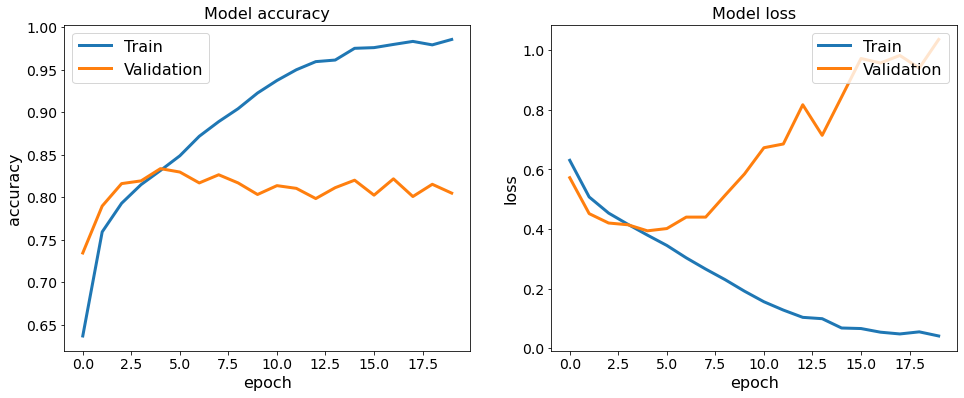

In [68]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [61]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [63]:
%%time
y_train_pred = model.predict_classes(X_train)
y_val_pred = model.predict_classes(X_val)

CPU times: user 13.1 s, sys: 4.36 s, total: 17.5 s
Wall time: 13.2 s


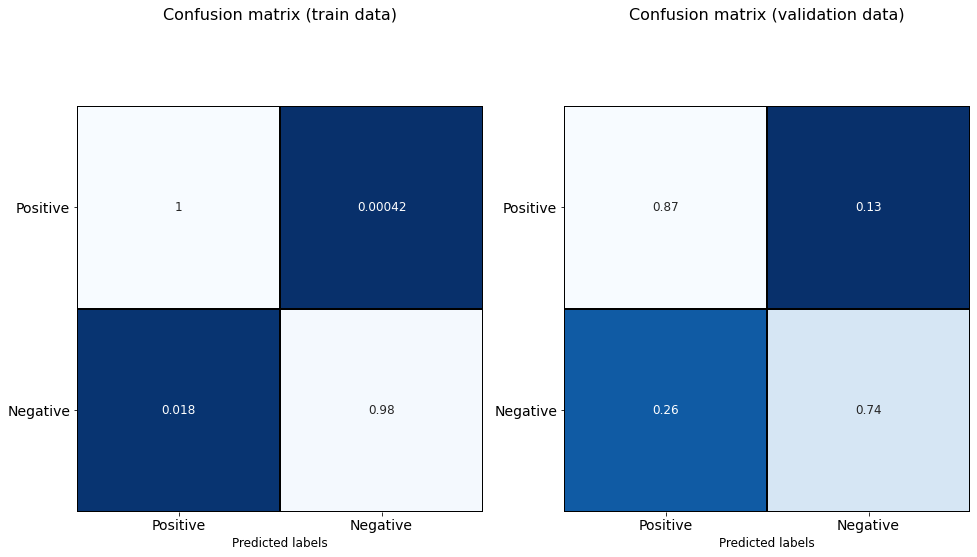

In [64]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_val, y_val_pred, ax=axis2,
                      title='Confusion matrix (validation data)',
                      class_names=['Positive', 'Negative'])